Preparing Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv(('/content/drive/MyDrive/financial_data.csv'))

In [ ]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


(6362620, 11)

In [ ]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [ ]:
df.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


Analysing Data(EDA)

In [ ]:
df['isFraud'].value_counts()

,count
isFraud,
0,6354407
1,8213


In [ ]:
fraud_percentage = (df['isFraud'].value_counts(normalize=True) * 100).round(2)
fraud_percentage

,proportion
isFraud,
0,99.87
1,0.13


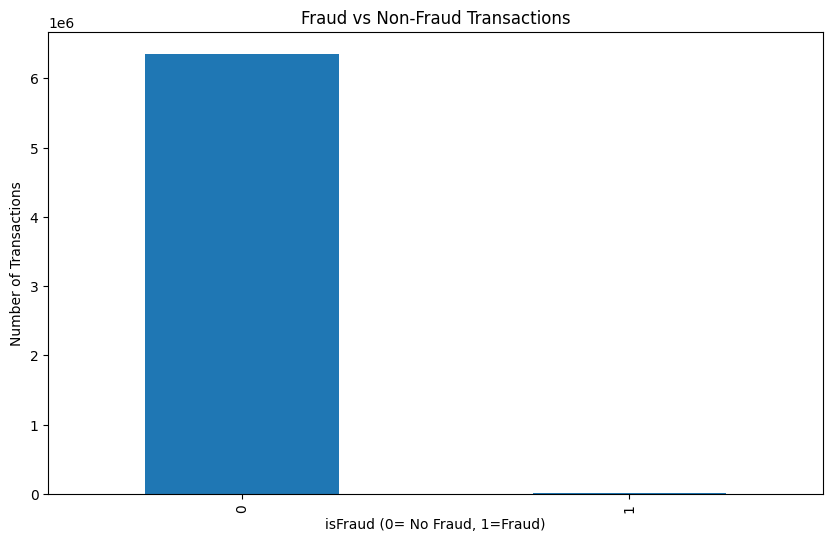

In [ ]:
import matplotlib.pyplot as plt
df['isFraud'].value_counts().plot(kind='bar', figsize = (10,6))
plt.title('Fraud vs Non-Fraud Transactions')
plt.xlabel('isFraud (0= No Fraud, 1=Fraud)')
plt.ylabel('Number of Transactions')
plt.show()

In [ ]:
non_fraud = df['isFraud'].value_counts()[0]
fraud = df['isFraud'].value_counts()[1]
imbalance_ratio = non_fraud/fraud
print(imbalance_ratio)

773.7010836478753


In [ ]:
fraud_by_type =df[df['isFraud'] == 1]['type'].value_counts()
fraud_by_type

,count
type,
CASH_OUT,4116
TRANSFER,4097


In [ ]:
total_by_type = df['type'].value_counts()
fraud_by_type =df[df['isFraud']== 1]['type'].value_counts()

In [ ]:
fraud_rate_by_type = (fraud_by_type / total_by_type * 100).sort_values(ascending= False)
fraud_rate_by_type

,count
type,
TRANSFER,0.768799
CASH_OUT,0.183955
CASH_IN,NaN
DEBIT,NaN
PAYMENT,NaN


Visualizations

Text(0, 0.5, 'Number of Fraud Cases')

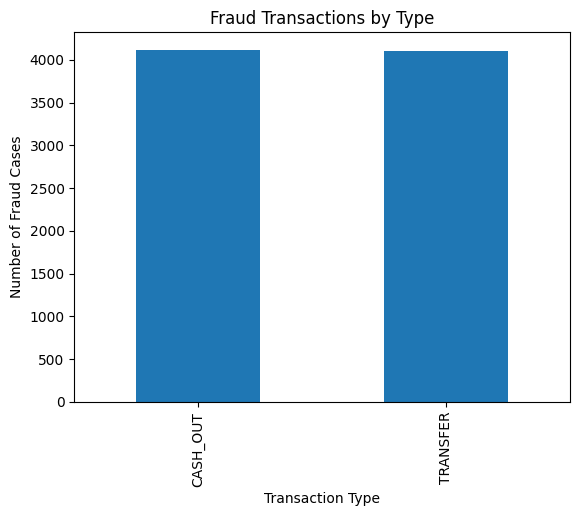

In [ ]:
fraud_by_type.plot(kind = 'bar')
plt.title('Fraud Transactions by Type')
plt.xlabel('Transaction Type')
plt.ylabel('Number of Fraud Cases')

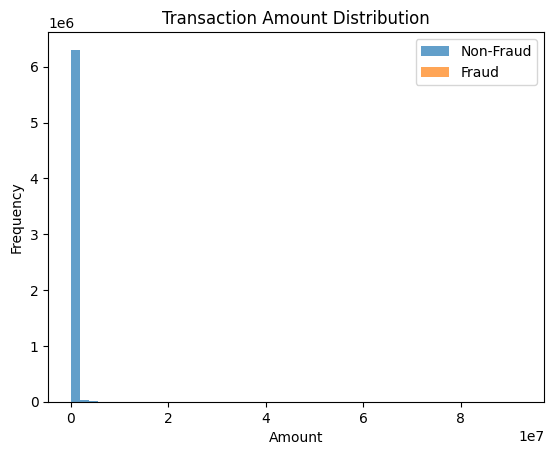

In [ ]:
fraud_amount = df[df['isFraud'] == 1]['amount']
non_fraud_amount = df[df['isFraud'] == 0]['amount']

plt.hist(non_fraud_amount, bins=50, alpha=0.7, label='Non-Fraud')
plt.hist(fraud_amount, bins=50, alpha=0.7, label='Fraud')

plt.legend()
plt.title('Transaction Amount Distribution')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

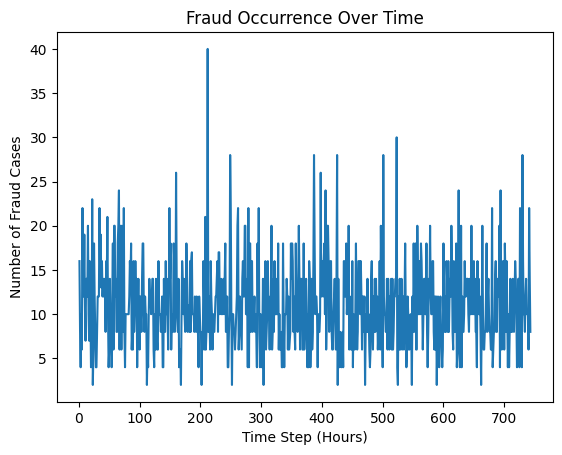

In [ ]:
fraud_over_time = df[df['isFraud']== 1]['step'].value_counts().sort_index()

plt.plot(fraud_over_time)
plt.title('Fraud Occurrence Over Time')
plt.xlabel('Time Step (Hours)')
plt.ylabel('Number of Fraud Cases')
plt.show()

Feature Engineering

In [ ]:
# Drop ID-like columns
df = df.drop(['nameOrig', 'nameDest'], axis=1)

In [ ]:
# Feature engineering
df['balance_diff_orig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['balance_diff_dest'] = df['newbalanceDest'] - df['oldbalanceDest']

# One-hot encode transaction type
df = pd.get_dummies(df, columns=['type'], drop_first=True)

X = df.drop('isFraud', axis=1)
y = df['isFraud']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X.shape, y.shape

((6362620, 13), (6362620,))

Model Selection

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [ ]:
# Check class distribution in train set
y_train.value_counts(normalize=True) * 100

,proportion
isFraud,
0,99.870926
1,0.129074


In [ ]:
# Check class distribution in test set
y_test.value_counts(normalize=True) * 100

,proportion
isFraud,
0,99.870887
1,0.129113


##Logistic Regression

In [ ]:
#baseline modeling

from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

#predictions
y_pred = log_reg.predict(X_test)
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]

#Evaluate the model
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.91      0.47      0.62      1643

    accuracy                           1.00   1272524
   macro avg       0.95      0.73      0.81   1272524
weighted avg       1.00      1.00      1.00   1272524



In [ ]:
# ROC-AUC score
roc_auc_score(y_test, y_pred_prob)

np.float64(0.9862418691851692)

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[1270801,      80],
       [    877,     766]])

WEIGHTED LOGISTIC REGRESSION

In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg_weighted = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight={0: 1, 1: 10}
)

log_reg_weighted.fit(X_train, y_train)

LogisticRegression(class_weight={0: 1, 1: 10}, max_iter=1000, random_state=42)

In [ ]:
y_pred_w = log_reg_weighted.predict(X_test)
y_pred_prob_w = log_reg_weighted.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

print(classification_report(y_test, y_pred_w))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.53      0.67      0.59      1643

    accuracy                           1.00   1272524
   macro avg       0.76      0.83      0.80   1272524
weighted avg       1.00      1.00      1.00   1272524



In [ ]:
roc_auc_score(y_test, y_pred_prob_w)

np.float64(0.9948490314143329)

In [ ]:
confusion_matrix(y_test, y_pred_w)

array([[1269899,     982],
       [    542,    1101]])

RANDOM FOREST

In [ ]:
    #random forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight={0: 1, 1: 10},
    n_jobs=-1
)

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 10}, n_jobs=-1, random_state=42)

In [ ]:
#predictions

y_pred_rf = rf.predict(X_test)
y_pred_prob_rf = rf.predict_proba(X_test)[:, 1]

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.98      0.81      0.89      1643

    accuracy                           1.00   1272524
   macro avg       0.99      0.91      0.94   1272524
weighted avg       1.00      1.00      1.00   1272524



In [ ]:
roc_auc_score(y_test, y_pred_prob_rf)

np.float64(0.9971899382331324)

In [ ]:
confusion_matrix(y_test, y_pred_rf)

array([[1270847,      34],
       [    309,    1334]])

In [ ]:
#Threshold Tuning
# Probabilities for fraud class
y_prob_rf = rf.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report, confusion_matrix

def evaluate_threshold(threshold):
    y_pred_thresh = (y_prob_rf >= threshold).astype(int)
    print(f"\nThreshold: {threshold}")
    print(classification_report(y_test, y_pred_thresh))
    print(confusion_matrix(y_test, y_pred_thresh))

for t in [0.2, 0.3, 0.4, 0.5, 0.6]:
    evaluate_threshold(t)


Threshold: 0.2
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.86      0.91      0.88      1643

    accuracy                           1.00   1272524
   macro avg       0.93      0.96      0.94   1272524
weighted avg       1.00      1.00      1.00   1272524

[[1270634     247]
 [    143    1500]]

Threshold: 0.3
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.91      0.87      0.89      1643

    accuracy                           1.00   1272524
   macro avg       0.96      0.94      0.95   1272524
weighted avg       1.00      1.00      1.00   1272524

[[1270746     135]
 [    210    1433]]

Threshold: 0.4
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.95      0.84      0.89      1643

    accuracy                           1.00   1272524
  

Key Insight

Lower thresholds → catch more fraud → more false alarms

Higher thresholds → fewer false alarms → miss more fraud

Choose threshold based on business priorities


FOR EXAMPLE
If catching fraud is critical (high financial cost), choose threshold = 0.2–0.3
If false alerts are costly, choose threshold = 0.4–0.5

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature names
feature_names = X.columns

# Get feature importances from Random Forest
importances = rf.feature_importances_

# Create a DataFrame for easy plotting
feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

feat_imp.head(10)

,Feature,Importance
7,balance_diff_orig,0.333364
8,balance_diff_dest,0.136674
5,newbalanceDest,0.115100
2,oldbalanceOrg,0.102558
1,amount,0.101956
0,step,0.062309
3,newbalanceOrig,0.044900
12,type_TRANSFER,0.043032
4,oldbalanceDest,0.037683
9,type_CASH_OUT,0.017979


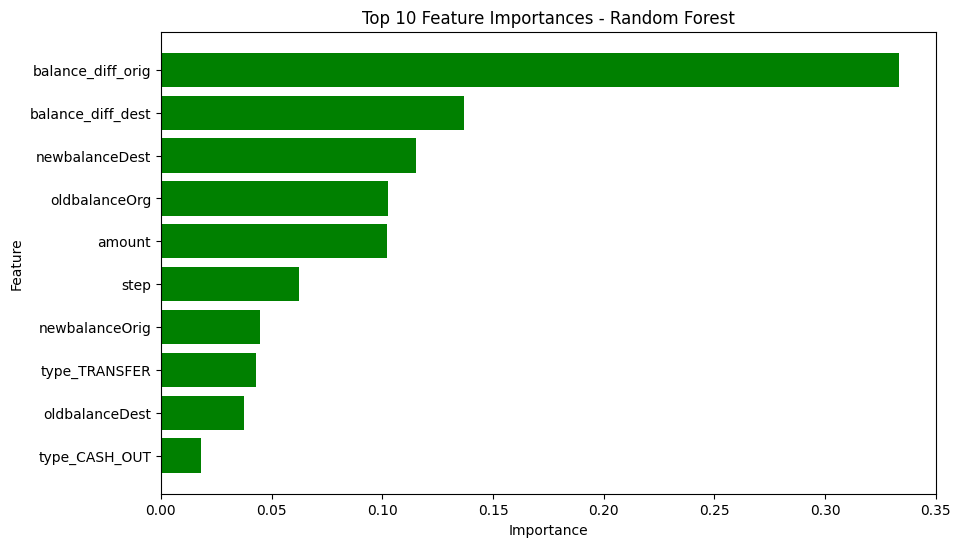

In [ ]:
plt.figure(figsize=(10,6))
plt.barh(feat_imp['Feature'][:10][::-1], feat_imp['Importance'][:10][::-1], color='green')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances - Random Forest')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Metrics for each model (fill with your actual results)
models = ['LogReg', 'LogReg Weighted', 'Random Forest', 'Isolation Forest']
roc_auc = [0.986, 0.995, 0.997, 0.90]
recall = [0.47, 0.67, 0.81, 0.55]
precision = [0.91, 0.91, 0.97, 0.20]

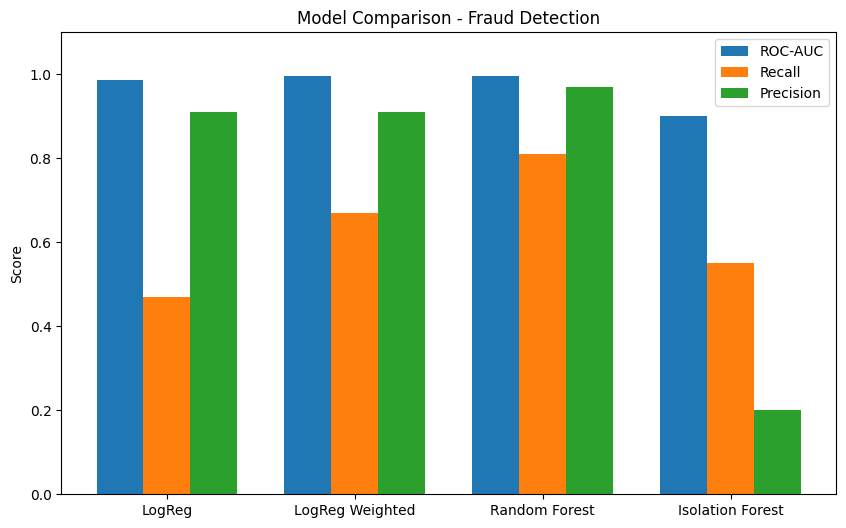

In [ ]:
import numpy as np

x = np.arange(len(models))
width = 0.25

plt.figure(figsize=(10,6))

plt.bar(x - width, roc_auc, width, label='ROC-AUC')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, precision, width, label='Precision')

plt.xticks(x, models)
plt.ylabel('Score')
plt.ylim(0,1.1)
plt.title('Model Comparison - Fraud Detection')
plt.legend()
plt.show()

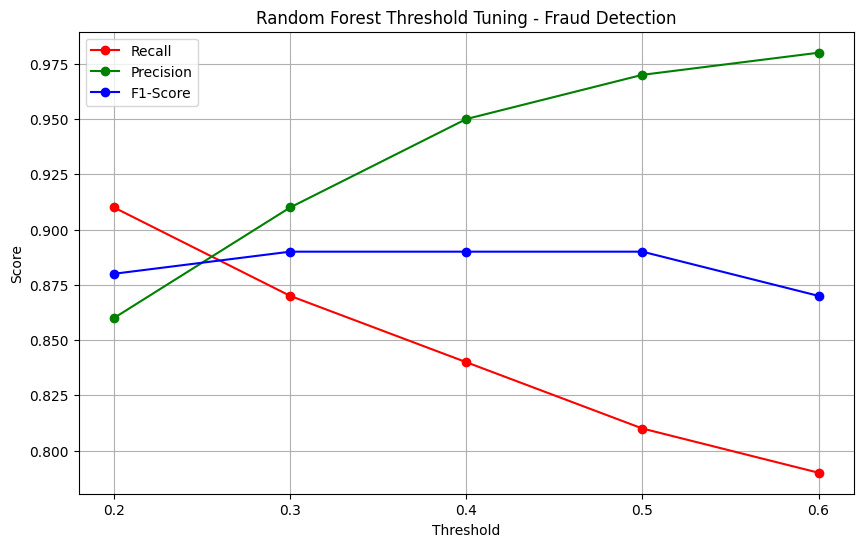

In [ ]:
import matplotlib.pyplot as plt

# Thresholds you tested
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6]

# Corresponding metrics (from your earlier output)
recall_values = [0.91, 0.87, 0.84, 0.81, 0.79]
precision_values = [0.86, 0.91, 0.95, 0.97, 0.98]
f1_values = [0.88, 0.89, 0.89, 0.89, 0.87]


plt.figure(figsize=(10,6))

plt.plot(thresholds, recall_values, marker='o', label='Recall', color='red')
plt.plot(thresholds, precision_values, marker='o', label='Precision', color='green')
plt.plot(thresholds, f1_values, marker='o', label='F1-Score', color='blue')

plt.xticks(thresholds)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Random Forest Threshold Tuning - Fraud Detection')
plt.legend()
plt.grid(True)
plt.show()